In [1]:
import numpy as np
import pandas as pd
import os
import subprocess
import time
import matplotlib.pyplot as plt
import itertools
from copy import deepcopy

from rdkit import Chem
from rdkit.Chem import AllChem
import ase
from ase.io import read, write
from ase.units import Hartree
from ase.visualize import view

from ase.io.trajectory import Trajectory
import glob
import pickle

In [2]:
from osc_discovery.photocatalysis.thermodynamics.constants import dG1_REST, dG2_REST, dG3_REST, dG4_REST

In [3]:
def free_energy_multidim(Gs, GOH, GO, GOOH, explicitly_broadcast=True):
    # Vectorized free energy expressions with numpy broadcasting
    # Gs : scalar, G*: arbitrary length numpy array
    # (OH_index, O_index, OOH_index)
    
    g1 = GOH[:, None, None] - Gs + dG1_REST
    g2 = GO[None, :, None] - GOH[:, None, None] + dG2_REST
    g3 = GOOH[None, None, :] - GO[None, :, None] + dG3_REST
    g4 = Gs - GOOH[None, None, :] + dG4_REST
    
    if explicitly_broadcast:
        tot_shape = len(GOH), len(GO), len(GOOH)
        g1b, g2b, g3b, g4b = explicitly_broadcast_to(tot_shape, g1, g2, g3, g4)
        G = np.moveaxis(np.array((g1b, g2b, g3b, g4b)), 0,3)
        return G
    else:
        return g1, g2, g3, g4
    
def free_energy(Gs, GOH, GO, GOOH):
    g1 = GOH - Gs + dG1_REST
    g2 = GO - GOH+ dG2_REST
    g3 = GOOH - GO + dG3_REST
    g4 = Gs - GOOH + dG4_REST
    
    return np.array([g1, g2, g3, g4])

def explicitly_broadcast_to(shape, *gs_expres):
    # Fillout arrays
    out = []
    for g in gs_expres:
        out.append(np.broadcast_to(g, shape))
    return tuple(out)

In [4]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

In [5]:
### For automatically reloading import modules... allows you to run changes to code in jupyter without having to reload
%load_ext autoreload
%autoreload 2

# Read Dataframe containing entire chemical space
path = os.getcwd() + '/data/'
file = 'df_chemical_space_chons_4rings.json'
p = pd.read_json(path+file, orient='split')

# Change dir
os.chdir('/home/scakolli/Thesis/osc_discovery/run')

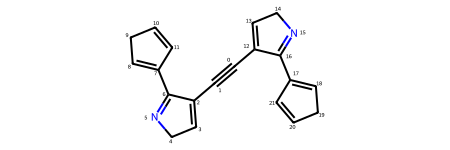

In [38]:
# Pick a random molecule in the space and get its smile string
rand_i = np.random.randint(315451)
# p.iloc[rand_i]

smi = p.iloc[rand_i]['molecule_smiles']
# smi = 'C1=CC(C=Cc2cnnc(-c3cc(C=CC4=CCC=C4)cnn3)c2)=CC1'
# smi = 'C1=CSC(=C2C(C=Cc3ccco3)=CC=C2C=Cc2ccco2)S1'

# Draw chem
rdkit_smi = Chem.MolFromSmiles(smi)
rdkit_smi

----

In [11]:
from osc_discovery.photocatalysis.adsorption.tools import prepare_substrate
from osc_discovery.photocatalysis.thermodynamics.tools import single_run, multi_run
from osc_discovery.photocatalysis.thermodynamics.constants import SHE_VACUUM_POTENTIAL

In [12]:
from osc_discovery.photocatalysis.adsorption.tools import build_configurations, get_adsorbate_conformers
# from osc_discovery.photocatalysis.adsorption.optimal_configurations import filter_configurations_with_symm, filter_configurations

In [14]:
# Prepare Substrate
calc_params = {'gfn':2, 'acc':0.2, 'etemp':298.15, 'strict':'', 'gbsa':'water'}
sub = prepare_substrate(smi, calc_params, multi_process_conf=2, multi_process_sp=4)

Number of rotatable bonds: 4, C1=CC(c2cncc(C3=CCC=C3)c2C=Cc2cc[nH]c2)=CC1
1) Embedding conformers (50). Using 2 processes
Took: 0.7358982563018799 s
2) Minimizing 50 conformers (mmff94)
Took: 1.5466482639312744 s
3) Pruning conformers (RMSD threshold: 0.35 Ang)
Took: 1.1832714080810547 s
Number of conformers found: 19


In [15]:
sub = single_run(sub, runtype='vipea', **calc_params, parallel=2)
ipshe = sub.info['ip'] / 1. - SHE_VACUUM_POTENTIAL
ipshe

1.1827999999999994

In [ ]:
sub_vacuum = single_run(sub, runtype='vipea', **{'acc':0.2, 'etemp':298.15, 'strict':''})
ipshe_vacuum = sub_vacuum.info['ip'] / 1. - SHE_VACUUM_POTENTIAL
ipshe_vacuum

In [ ]:
mol = Chem.MolFromSmiles(smi)
mol.__sssAtoms = [*sub.info['equivalent_atoms']]
mol

Testing

In [16]:
from osc_discovery.photocatalysis.adsorption.relaxing import build_and_relax_configurations, build_configurations

#### Build and relax configs

In [ ]:
### Build Configs
configsOH, configsO, configsOOH = build_configurations(sub, sub.info['equivalent_atoms'])

In [ ]:
start = time.perf_counter()
oh = multi_run(configsOH, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o = multi_run(configsO, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh = multi_run(configsOOH, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

In [ ]:
### Filtering
oh = filter_configurations_with_symm(oh, sub)
o = filter_configurations_with_symm(o, sub)
ooh = filter_configurations_with_symm(ooh, sub)
print("Num configs", len(oh), len(o), len(ooh))
print("Took", time.perf_counter()-start)

In [ ]:
start = time.perf_counter()

### Hessian
oh = multi_run(oh, runtype='hess', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o = multi_run(o, runtype='hess', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh = multi_run(ooh, runtype='hess', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

### Info
print("Total Time", time.perf_counter()-start)

In [ ]:
### Crude Relaxation
start = time.perf_counter()
oh_crude = multi_run(configsOH, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o_crude = multi_run(configsO, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh_crude = multi_run(configsOOH, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

In [ ]:
### Filtering
oh_crude = filter_configurations_with_symm(oh_crude, sub)
o_crude = filter_configurations_with_symm(o_crude, sub)
ooh_crude = filter_configurations_with_symm(ooh_crude, sub)
print("Num configs", len(oh_crude), len(o_crude), len(ooh_crude))

In [ ]:
es = sub.info['energy']
eoh = np.array([t.info['energy'] for t in oh])
eo = np.array([t.info['energy'] for t in o])
eooh = np.array([t.info['energy'] for t in ooh])

eoh_crude = np.array([t.info['energy'] for t in oh_crude])
# eoh_crude = np.delete(eoh_crude, 3)
eo_crude = np.array([t.info['energy'] for t in o_crude])
eooh_crude = np.array([t.info['energy'] for t in ooh_crude])

asoh = np.array([t.info['active_site'] for t in oh])
aso = [t.info['active_site'] for t in o]
asooh = np.array([t.info['active_site'] for t in ooh])

activesites = [[i, j, k] for i, j, k in itertools.product(asoh, aso, asooh)]
activesites = np.array(activesites).reshape(len(asoh), len(aso), len(asooh), 3)

In [ ]:
# Info
zpes = sub.info['zpe']
ss = sub.info['entropy']

zpeoh = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in oh])
zpeo = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in o])
zpeooh = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in ooh])

soh = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in oh])
so = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in o])
sooh = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in ooh])

Crude

In [ ]:
eooh_crude.argsort(), eooh.argsort()

In [ ]:
stable_config_indx, stable_config_indx_crude = (int(eoh.argmin()), int(eo.argmin()), int(eooh.argmin())), (eoh_crude.argmin(), eo_crude.argmin(), eooh_crude.argmin())

In [ ]:
stable_config_indx, stable_config_indx_crude

In [ ]:
asoh[eoh.argsort()], np.array(aso)[eo.argsort()], asooh[eooh.argsort()]

In [ ]:
mol = Chem.MolFromSmiles(smi)
mol.__sssAtoms = [*stable_config_indx]
mol

Most stable configuration in the sense of Energy OR E+ZPE / G=E+ZPE-TS.... if its the latter, then we need ZPE-TS approximation for all configs... if its the former, then only 3 ZPE calcs required, or perhaps only one?

#### ZPE-TS

In [ ]:
stable_config = [oh[stable_config_indx[0]], o[stable_config_indx[1]], ooh[stable_config_indx[2]]]

In [ ]:
stable_config = multi_run(stable_config, runtype='hess --parallel 2', keep_folders=False, calc_kwargs=calc_params, multi_process=3)

Testing

In [ ]:
G = free_energy_multidim(es+zpes-ss, eoh+zpeoh-soh, eo+zpeo-so, eooh+zpeooh-sooh)
overpot = G.max(axis=3) - 1.23

Gcrude = free_energy_multidim(es+zpes-ss, eoh_crude+zpeoh[9]-soh[9], eo_crude+zpeo[0]-so[0], eooh_crude+zpeooh[5]-sooh[5])
overpotcrude = Gcrude.max(axis=3) - 1.23

In [ ]:
plt.scatter(overpotcrude.flatten(), overpot.flatten())

In [ ]:
np.mean(abs(overpotcrude.flatten() - overpot.flatten()))

In [ ]:
stable_config_indx

In [ ]:
free_energy(es, eoh[9], eo[0], eooh[5])

In [ ]:
G[9,0,5], Gcrude[9, 0, 5]

In [ ]:
G[9, 0, 5], Gcrude[9, 0, 5]

In [ ]:
free_energy(es+zpes-ss, eoh[9]+zpeoh[9]-soh[9], eo[0]+zpeo[0]-so[0], eooh[5]+zpeooh[5]-sooh[5])

In [ ]:
free_energy(es+zpes-ss, eoh[9]+zpes-ss, eo[0]+zpeo[0]-so[0], eooh[5]+zpeooh[5]-sooh[5])

---

In [17]:
from osc_discovery.photocatalysis.adsorption.relaxing import filter_configurations

Testing hypothesis, that its sufficient to only consider a hanful of sites

In [18]:
n_strings = 15
smile_strings = [p.iloc[ri]['molecule_smiles'] for ri in np.random.randint(315451, size=n_strings)]

In [47]:
calc_params = {'gfn':2, 'acc':0.2, 'etemp':298.15, 'strict':'', 'gbsa':'water'}
master = []
opt = []
test = []
times = []

for j, s in enumerate(smile_strings):
    ## Prepare Substrate
    start = time.perf_counter()
    sub = prepare_substrate(s, calc_params, multi_process_conf=2, multi_process_sp=4)
    
    ### VIPEA
    sub = single_run(sub, runtype='vipea', **calc_params)
    ipshe = sub.info['ip'] / 1. - SHE_VACUUM_POTENTIAL
    
    ### Build Configs
    configsOH, configsO, configsOOH = build_configurations(sub, sub.info['equivalent_atoms'])
    
    ### Crude Relaxation
    oh  = multi_run(configsOH, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
    o = multi_run(configsO, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
    ooh = multi_run(configsOOH, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
    
    ## Filter
    oh = filter_configurations(oh, sub)
    o = filter_configurations(o, sub)
    ooh = filter_configurations(ooh, sub)

    ### Info
    es = sub.info['energy']
    eoh = np.array([t.info['energy'] for t in oh])
    eo = np.array([t.info['energy'] for t in o])
    eooh = np.array([t.info['energy'] for t in ooh])

    asoh = np.array([t.info['active_site'] for t in oh])
    aso = [t.info['active_site'] for t in o]
    asooh = np.array([t.info['active_site'] for t in ooh])
    activesites = [[i, j, k] for i, j, k in itertools.product(asoh, aso, asooh)]
    activesites = np.array(activesites).reshape(len(asoh), len(aso), len(asooh), 3)

    ### Free Energies
    ioh, io, iooh = eoh.argmin(), eo.argmin(), eooh.argmin()

    # Optimzie and perform hessian calc
    stable_configs = [oh[ioh], o[io], ooh[iooh]]
    stable_configs = multi_run(stable_configs, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=3)
    stable_configs = multi_run(stable_configs, runtype='hess', keep_folders=False, calc_kwargs=calc_params, multi_process=3)

    es = sub.info['energy']
    zpes, ss = sub.info['zpe'], sub.info['entropy']
    eoh, zpeoh, soh = stable_configs[0].info['energy'], stable_configs[0].info['zpe'], stable_configs[0].info['entropy']
    eo, zpeo, so = stable_configs[1].info['energy'], stable_configs[1].info['zpe'], stable_configs[1].info['entropy']
    eooh, zpeooh, sooh = stable_configs[2].info['energy'], stable_configs[2].info['zpe'], stable_configs[2].info['entropy']

    dGs = free_energy(es+zpes-ss, eoh+zpeoh-soh, eo+zpeo-so, eooh+zpeooh-sooh)
    #dGs_complete = free_energy_multidim(es+zpes-ss, eoh+zpeoh-soh, eo+zpeo-so, eooh+zpeooh-sooh)
    #overpot_complete = dGs_complete.max(axis=3)-1.23
    #overpot_complete.min(), np.unravel_index(overpot_complete.argmin(), overpot_complete.shape)


    master.append([activesites[ioh, io, iooh].tolist(), ipshe, dGs.max()])
    #opt.append([np.unravel_index(overpot_complete.argmin(), overpot_complete.shape), overpot_complete.min()])
    #test.append([eoh.argsort(), eo.argsort(), eooh.argsort()])
    times.append(time.perf_counter()-start)
    print('########################################')
    print("Sub", j,"took", time.perf_counter()-start)
    print('########################################')
    
    break

2023-06-21 19:51:59,097 | INFO: Jobs to do: 3
2023-06-21 19:52:02,819 | INFO: Finished jobs. Took 3.7191162000017357s
2023-06-21 19:52:02,826 | INFO: Jobs to do: 3
2023-06-21 19:52:18,087 | INFO: Finished jobs. Took 15.259695600005216s


########################################
Sub 0 took 372.577844200001
########################################


### Perspective and proposed workflow

We want to evaluate whether p-doped (i.e. electron poor) organic semiconductor monomers are suitable for photocatalytic oxygen production (and perhaps Hydrogen production as well, but theres no gaurentee that electron poor substrates can be good enough donors for HER). In this regard, 3 things are important:

1) Suitability as a photocatalyst
Does the catalyst posses a sufficient thermodynamic driving force for charge transfer; is the IP larger than the Redox potential for water oxidation (1.23 V at STP)?

In a realistic system, we have to consider the excited state electron affinity (EA*) of the catalyst; the catalysts ability to accept an electron into its vacant HOMO orbital. If we assume that the electron-hole pair generated upon photoexcitation is thermalized and separated (i.e. we've provided enough energy to overcome the exciton binding energy), then we can approximate EA* with the IP. The exciton binding energy turns out to be quite substantial for organic polymers at room temperature, but solvation stablizes EA* and destabilizes IP, in such a way that with increasing dielectric constant of the medium, we get a converging of the 2 quantities (difference on the order of ~ 0.2 eV). In fact, if we wanted to be really cheap about the IP, we could approximate it with the HOMO energy, but this is not perfect, and since the majority of our computational resources are devoted to elucidating electrocatalytic active sites, we can perform the slightly more expensive computation of determining IP.

IPEA-xTB has been specially parameterized for determining IP's, but it is still likely that this measure is not accurate enough for our purposes (especially because its a vertical potential that ignores nuclear relaxation). In literature, the IP-xTB is correlated with IP-DFT (adiabatic), so that we can gain a more accurate depiction of the redox capability of our catalyst.

Note: Harald wants to incorporate this IP directly into the free energy expression by treating the protons in a slightly different way. If we correlate these IPs with DFT derived values, I wonder if this would be a wise thing to do..?

2) Suitability as an electrocatalyst
Does the catalyst bind the intermediates in such a way that there is a limited overpotential?

In an ideal catalyst, we want each intermediate to bind to the catalyst just right (in accordiance with the sabitier principle) and in the situation of water splitting, 'just-right' amounts to a free energy change of 1.23 eV for each step. The more symmetric each step is in terms of free energy, the better is ability to catalyze the reaction. Using a sabitier analysis
Rate = min(R1_max, R2_max, R3_max, R4_max) which directly translates to determining the thermodynamic overpotential, and the ESSI (electrochemical step symmetry index) or an equivalent measure of symmetry (MAD), we evaluate how efficient our catalyst is predicted to be in a kinetic sense.

If the Ionization potential is greated than the free energy change of the rate determining step (i.e. G.max(axis=3)), then the photocatalyst is expected to oxidize water!

#### Things to do

1) Resolve ambiguities about IP-xTB (specifically concerning this empirical shift) and correlate these with IP-DFT
2) Incorporate IP into the free energy expression (see Haralds Gold Nanorods paper)
3) Determine whether these 2 things could place nice together... is it reasonable to combine these results
4) HOMO energies instead
4) Do our IP's change much conformer to conformer? Literature says no, but verifying would be good
5) xTB-STDA for TD exciton binding energies and optical gap
6) Fukui/partial charge scheme proposed earlier may be helpful
7) FF's for finding most stable site (see also GFNFF)
8) FF's for optimizing molecules... do they correlate with xTB energies?
----------------------------------------------

9) Fix filter_configurations() and perhaps discontinue use of the symmetry variant...
10) Introduce 'ohess' runtype and parsing
11) Fix any bugs left in the code
12) Clean up modules
------------------------------------------

13) Log into clusters on campus and get some runs going
14) create master_function to be called that evaluates a given molecule
15) Start thinking about different molecules to implement (DA architectures, etc.)

# 5) IP variation and conformers

0.034eV 2sigma variation across 15 confs, 0.12 eV variation in the worst case (vtight optimized)
0.066eV 2sigma variation across 15 confs, 0.17 eV variation in the worst case (loose optimized)
0.056eV, 0.16eV (FF optimized)

Regardless of optimization method, IP does not variation much at all between conformer.
However, 0.15eV mean variation between vtight and ff optimized structures (0.46eV in the worst case)
And, 0.034eV mean variation between vtight and loosely optimized (0.1729eV in worst case)
Completely optimized conformers in general have the lowest IP's...

##### Conclusion:
The most realistic picture determined with moderate computational effort, is offered by 1 completely optimized conformer (lowest IP amongst optimization schemes, providing worst case driving force) that is on average 0.03eV away from other confs in IP (0.1eV in the worst case). 

Perform this analysis on multiple representative IP's!

In [ ]:
from osc_discovery.descriptor_calculation.conformers import get_conformers_rdkit as get_conformers

In [ ]:
n_strings = 15
smile_strings = [p.iloc[ri]['molecule_smiles'] for ri in np.random.randint(315451, size=n_strings)]

In [ ]:
calc_params = {'gfn':2, 'acc':0.2, 'etemp':298.15, 'strict':''} #, 'gbsa':'water'}
confs_props = []

for j, s in enumerate(smile_strings):
    props = []
    start = time.perf_counter()
    
    ### Prepare Substrate
    sub_confs = get_conformers(s, n_cpu=2)
    
    for sc in sub_confs:
        ### VIPEA
        conf = single_run(sc, runtype='vipea', **calc_params)
        ip = conf.info['ip'] / 1. - SHE_VACUUM_POTENTIAL
        ehomo = conf.info['ehomo'] / -1. - SHE_VACUUM_POTENTIAL
        
        props.append([ip, ehomo])
    
    confs_props.append(props)
    print("Took ", time.perf_counter() - start)
    print("#####################################")

In [ ]:
calc_params = {'gfn':2, 'acc':0.2, 'etemp':298.15, 'strict':''} #, 'gbsa':'water'}
confs_props_loose = []
confs_props_vtight = []

for j, s in enumerate(smile_strings):
    props_loose = []
    props_vtight = []
    start = time.perf_counter()
    sub_confs = get_conformers(s, n_cpu=2)
    
    ### Loose
    sub_confs_loose = multi_run(sub_confs, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=4)
    
    for sc in sub_confs_loose:
        ### VIPEA
        conf = single_run(sc, runtype='vipea', **calc_params)
        ip = conf.info['ip'] / 1. - SHE_VACUUM_POTENTIAL
        ehomo = conf.info['ehomo'] / -1. - SHE_VACUUM_POTENTIAL
        
        props_loose.append([ip, ehomo])
    
    confs_props_loose.append(props_loose)
    
    ### Very tight
    sub_confs_vtight = multi_run(sub_confs_loose, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=4)
    
    for sc in sub_confs_vtight:
        ### VIPEA
        conf = single_run(sc, runtype='vipea', **calc_params)
        ip = conf.info['ip'] / 1. - SHE_VACUUM_POTENTIAL
        ehomo = conf.info['ehomo'] / -1. - SHE_VACUUM_POTENTIAL
        
        props_vtight.append([ip, ehomo])
    
    confs_props_vtight.append(props_vtight)
    
    print("Took ", time.perf_counter() - start)
    print("#####################################")

In [ ]:
h = [[2*np.array(cf)[:, 0].std(), 2*np.array(cl)[:, 0].std(), 2*np.array(cv)[:, 0].std()] for cf, cl, cv in zip(confs_props, confs_props_loose, confs_props_vtight)]

In [ ]:
np.array(h).mean(axis=0)

In [ ]:
g = np.array([[np.array(cf)[:, 0].mean(), np.array(cl)[:, 0].mean(), np.array(cv)[:, 0].mean()] for cf, cl, cv in zip(confs_props, confs_props_loose, confs_props_vtight)])

In [ ]:
(g[:, 1] - g[:, 2]).max()

## 8/9) FF's

FF optimized molecules (whether MMFF98 or GFNFF) with subsequent xTB single point evaluation, overestimate the energy and fail to reproduce the more accurate energies and ordering of configurations w.r.t. energy... sometimes these methods can locate the most stable site, other times not so much. Errors in energy on the order of 1-4 eV (especially bad for oxygen intermediate).

In [ ]:
from rdkit.Chem import AllChem
from osc_discovery.photocatalysis.adsorption.helpers import ase2rdkit_valencies
from osc_discovery.cheminformatics.cheminformatics_misc import rdkit2ase

In [ ]:
def generate_opt_confs(molecule, numConfs=10, numThreads=4):
    mol = ase2rdkit_valencies(molecule)
    AllChem.EmbedMultipleConfs(mol, numConfs=numConfs, numThreads=numThreads)
    ff_opt_energies = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=numThreads)
    
    conformers = [rdkit2ase(mol, confId=j) for j in range(mol.GetNumConformers())]
    # conformers_sorted = [c for _, c in sorted(zip(ff_opt_energies, conformers), key=lambda x: x[0][1])]
    conformers_sorted = []
    for e, c in sorted(zip(ff_opt_energies, conformers), key=lambda x: x[0][1]):
        c.info['energy'] = e[1]
        conformers_sorted.append(c)
        
    return conformers_sorted

In [ ]:
qs = np.array([sub.info['qs'][i] for i in sub.info['equivalent_atoms']])
qs = sub.info['qs']

In [ ]:
### Prepare Substrate
calc_params = {'gfn':2, 'acc':0.2, 'etemp':298.15, 'strict':''} #, 'gbsa':'water'}
sub, _ = prepare_substrate(smile_strings[11], calc_params, multi_process_conf=2, multi_process_sp=4)

In [ ]:
### Build Configs
configsOH, configsO, configsOOH = build_configurations(sub, key='equivalent_atoms')

### FF optimize configurations
start = time.perf_counter()
ohff = [generate_opt_confs(c)[0] for c in configsOH]
off = [generate_opt_confs(c)[0] for c in configsO]
oohff = [generate_opt_confs(c)[0] for c in configsOOH]

ohff  = multi_run(ohff, runtype='sp', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
off = multi_run(off, runtype='sp', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
oohff = multi_run(oohff, runtype='sp', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

### GFNFF optimized
ff_calc_params = {'gfnff':'', 'acc':0.2, 'etemp':298.15}
ohgff  = multi_run(configsOH, runtype='opt vtight', keep_folders=False, calc_kwargs=ff_calc_params, multi_process=6)
ogff = multi_run(configsO, runtype='opt vtight', keep_folders=False, calc_kwargs=ff_calc_params, multi_process=6)
oohgff = multi_run(configsOOH, runtype='opt vtight', keep_folders=False, calc_kwargs=ff_calc_params, multi_process=6)

ohgff  = multi_run(ohgff, runtype='sp', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ogff = multi_run(ogff, runtype='sp', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
oohgff = multi_run(oohgff, runtype='sp', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

# ohff = filter_configurations(ohff, sub)
# off = filter_configurations(off, sub)
# oohff = filter_configurations(oohff, sub)
print("FF opt took", time.perf_counter() - start)

### Loosely optimize configs
start = time.perf_counter()
oh  = multi_run(configsOH, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o = multi_run(configsO, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh = multi_run(configsOOH, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

# oh = filter_configurations(oh, sub)
# o = filter_configurations(o, sub)
# ooh = filter_configurations(ooh, sub)
print("xtb loose opt took", time.perf_counter() - start)

In [ ]:
eohff = np.array([t.info['energy'] for t in ohff])
eoff = np.array([t.info['energy'] for t in off])
eoohff = np.array([t.info['energy'] for t in oohff])

eohgff = np.array([t.info['energy'] for t in ohgff])
eogff = np.array([t.info['energy'] for t in ogff])
eoohgff = np.array([t.info['energy'] for t in oohgff])

eoh = np.array([t.info['energy'] for t in oh])
eo = np.array([t.info['energy'] for t in o])
eooh = np.array([t.info['energy'] for t in ooh])

In [ ]:
plt.scatter(eoh, eohff)
plt.scatter(eoh, eohgff)
plt.plot(eoh, eoh, 'r')

In [ ]:
plt.scatter(eo, eoff)
plt.scatter(eo, eogff)
plt.plot(eo, eo, 'r')

In [ ]:
# plt.scatter(eooh, eoohff)
plt.scatter(eooh, eoohgff)
plt.plot(eooh, eooh, 'r')

In [ ]:
eohff.argsort(), eoff.argsort(), eoohff.argsort()

In [ ]:
eohgff.argsort(), eogff.argsort(), eoohgff.argsort()

In [ ]:
eoh.argsort(), eo.argsort(), eooh.argsort()

perhaps using FF's to speed up optimization?

Turns out to be faster, but doesn't reproduce loose opt. Still might be useful to generate additional confs though

In [ ]:
### Loosely optimize configs
start = time.perf_counter()
oh  = multi_run(configsOH, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o = multi_run(configsO, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh = multi_run(configsOOH, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
print("xtb loose opt took", time.perf_counter() - start)

In [ ]:
### GFNFF optimized, and subsequent loose opt
start = time.perf_counter()
ff_calc_params = {'gfnff':'', 'acc':0.2, 'etemp':298.15}
ohgff  = multi_run(configsOH, runtype='opt vtight', keep_folders=False, calc_kwargs=ff_calc_params, multi_process=6)
ogff = multi_run(configsO, runtype='opt vtight', keep_folders=False, calc_kwargs=ff_calc_params, multi_process=6)
oohgff = multi_run(configsOOH, runtype='opt vtight', keep_folders=False, calc_kwargs=ff_calc_params, multi_process=6)

ohgff  = multi_run(ohgff, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ogff = multi_run(ogff, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
oohgff = multi_run(oohgff, runtype='opt loose', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
print("xtb loose opt took", time.perf_counter() - start)

In [ ]:
eoh = np.array([t.info['energy'] for t in oh])
eo = np.array([t.info['energy'] for t in o])
eooh = np.array([t.info['energy'] for t in ooh])

eohgff = np.array([t.info['energy'] for t in ohgff])
eogff = np.array([t.info['energy'] for t in ogff])
eoohgff = np.array([t.info['energy'] for t in oohgff])

In [ ]:
eoh.argsort()

In [ ]:
eohgff.argsort()

In [ ]:
test = filter_configurations(oh, sub)
testff = filter_configurations(oh+ohgff, sub)

In [ ]:
np.array([t.info['energy'] for t in test]) - np.array([t.info['energy'] for t in testff])[:17]

In [ ]:
[t.info['active_site'] for t in test], [t.info['active_site'] for t in testff]

In [ ]:
np.array([t.info['energy'] for t in test]).argsort()

In [ ]:
np.array([t.info['energy'] for t in testff]).argsort()

## 7) Fukui and Partial charges

Not worth it

In [ ]:
sub = single_run(sub, runtype='vfukui', **calc_params)

In [ ]:
test = filter_configurations(oh, sub)

In [ ]:
qsoh = np.array([qs[t.info['active_site']] for t in test])
eoh_filt = np.array([t.info['energy'] for t in test])

In [ ]:
qsoh[eoh_filt.argsort()]

In [ ]:
eoh_filt.argsort()

In [ ]:
qsoh.argsort()[::-1]

Testing filter_configs

In [ ]:
from osc_discovery.photocatalysis.thermodynamics.constants import dG1_REST, dG2_REST, dG3_REST, dG4_REST

In [ ]:
dG1_REST, dG2_REST, dG3_REST, dG4_REST